# **Implementasi Voice Activity Detection pada Noisy Speech Menggunakan Zero Crossing Rate (ZCR) dan Short-Time Fourier Transform (STFT)**

# Signal Preprocessing

Import Library

In [ ]:
import numpy as np
import librosa
import soundfile as sf
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kode ini digunakan untuk memuat library yang diperlukan dalam pengolahan sinyal audio, di mana NumPy berperan dalam operasi numerik, Librosa dan SoundFile digunakan untuk membaca serta memproses file audio. Mount Google Drive dilakukan agar file audio yang tersimpan dapat diakses langsung dari lingkungan Google Colab.

Add White Gaussian Noise

In [ ]:
def add_white_gaussian_noise(signal, snr_target_db):
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_target_db / 10)
    noise_power = signal_power / snr_linear

    #  Generate White Gaussian Noise
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    noisy_signal = signal + noise

    return noisy_signal

Fungsi ini digunakan untuk menambahkan White Gaussian Noise (WGN) ke dalam sinyal audio berdasarkan nilai Signal-to-Noise Ratio (SNR) yang ditentukan. Daya sinyal dihitung terlebih dahulu, kemudian daya noise ditentukan sesuai dengan SNR target. Noise berdistribusi Gaussian dengan mean nol dihasilkan dan ditambahkan ke sinyal asli untuk menghasilkan sinyal audio yang terkontaminasi noise.

Framing

In [ ]:
def frame_signal(signal, sample_rate, frame_duration_ms=15, overlap_percent=0.5):
    frame_length = int(sample_rate * (frame_duration_ms / 1000))
    step_size = int(frame_length * (1 - overlap_percent)) # overlap 50%
    frames = librosa.util.frame(signal, frame_length=frame_length, hop_length=step_size).T #framing

    return frames, frame_length, step_size

Fungsi ini digunakan untuk membagi sinyal audio menjadi beberapa frame berdurasi pendek sebesar 15 ms dengan overlap sebesar 50%. Proses framing bertujuan untuk memungkinkan analisis sinyal dalam domain waktu pendek, yang umum digunakan dalam pengolahan sinyal suara. Fungsi ini menghasilkan kumpulan frame sinyal beserta panjang frame dan jarak antar frame (hop length).


Load Audio (8000 Hz), Normalisasi, Add Noise, Framing, Hamming Window

In [ ]:
import os
def apply_hamming(frames):
    hamming = np.hamming(frames.shape[1])
    return frames * hamming

Fungsi ini digunakan untuk menerapkan Hamming Window pada setiap frame sinyal audio. Penerapan window bertujuan untuk mengurangi efek diskontinuitas pada batas frame yang dapat menyebabkan spectral leakage pada analisis spektral.

In [ ]:
# Memuat file audio
audio_files = [
    "/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav",
    "/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav",
    "/content/drive/MyDrive/Project PSD  Kelompok 7/8555-292519-0003.wav",
    "/content/drive/MyDrive/Project PSD  Kelompok 7/rekaman.wav"
]

TARGET_SR = 8000
TARGET_SNR = 10  # dB untuk dataset clean saja

# Inisialisasi dictionary untuk menyimpan frames_hamming untuk setiap file
all_frames_hamming = {}

# Inisialisasi dictionary untuk menyimpan sinyal dan sample rate
all_signals = {}
all_sample_rates = {}

print(f"MULAI PROSES (Target SR: {TARGET_SR} Hz, SNR: {TARGET_SNR} dB) ---\n")

for file_name in audio_files:
    print(f"Memproses file: {file_name}")

    # Load & Resample (semua file)
    clean_signal, sr = librosa.load(file_name, sr=TARGET_SR)
    print(f"   -> Resampled ke {sr} Hz. Durasi: {len(clean_signal)/sr:.2f} detik")

    # Normalisasi
    max_val = np.max(np.abs(clean_signal))
    if max_val > 0:
        clean_signal = clean_signal / max_val
    print("   -> Normalisasi amplitudo dilakukan.")

    all_signals[file_name] = clean_signal
    all_sample_rates[file_name] = sr

    # Cek apakah file adalah rekaman asli
    if file_name == "rekaman.wav":
        noisy_signal = clean_signal
        print("   -> Ini rekaman asli, TIDAK ditambahkan noise.")
    else:
        noisy_signal = add_white_gaussian_noise(clean_signal, TARGET_SNR)
        print("   -> Noise Gaussian 10 dB ditambahkan.")

        # Extract base filename and extension
        base_name = os.path.basename(file_name)
        name_without_ext = os.path.splitext(base_name)[0]

        output_filename = f"noisy_{TARGET_SNR}dB_{name_without_ext}.wav"
        sf.write(output_filename, noisy_signal, sr)
        print(f"   -> File noisy disimpan: {output_filename}")


    # 4. Framing (sama untuk semuanya)
    frames, frame_len, hop_len = frame_signal(
        noisy_signal, sr,
        frame_duration_ms=15,
        overlap_percent=0.5
    )

    print(f"   -> Framing selesai.")
    print(f"      Panjang 1 Frame: {frame_len} sampel (15 ms)")
    print(f"      Total Frame terbentuk: {frames.shape[0]}")
    print(f"      Dimensi Matrix Frame: {frames.shape} (Frame x Sampel)")

    # 5. Hamming
    frames_hamming = apply_hamming(frames)
    all_frames_hamming[file_name] = frames_hamming # Simpan frames_hamming untuk file ini
    print("   -> Hamming Window diterapkan.\n")

MULAI PROSES (Target SR: 8000 Hz, SNR: 10 dB) ---

Memproses file: /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav
   -> Resampled ke 8000 Hz. Durasi: 3.27 detik
   -> Normalisasi amplitudo dilakukan.
   -> Noise Gaussian 10 dB ditambahkan.
   -> File noisy disimpan: noisy_10dB_1089-134686-0001.wav
   -> Framing selesai.
      Panjang 1 Frame: 120 sampel (15 ms)
      Total Frame terbentuk: 435
      Dimensi Matrix Frame: (435, 120) (Frame x Sampel)
   -> Hamming Window diterapkan.

Memproses file: /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav
   -> Resampled ke 8000 Hz. Durasi: 6.62 detik
   -> Normalisasi amplitudo dilakukan.
   -> Noise Gaussian 10 dB ditambahkan.
   -> File noisy disimpan: noisy_10dB_1089-134686-0002.wav
   -> Framing selesai.
      Panjang 1 Frame: 120 sampel (15 ms)
      Total Frame terbentuk: 882
      Dimensi Matrix Frame: (882, 120) (Frame x Sampel)
   -> Hamming Window diterapkan.

Memproses file: /content/drive/MyDr

Parameter ini menetapkan sampling rate target sebesar 8 kHz serta Signal-to-Noise Ratio (SNR) sebesar 10 dB untuk penambahan noise pada file audio tertentu.

Selanjutnya, setiap file audio diproses melalui beberapa tahapan, yaitu pemrosesan ulang sampling rate (resampling) ke 8 kHz, normalisasi amplitudo, serta penambahan White Gaussian Noise untuk file dataset non-rekaman. Sinyal yang telah diproses kemudian dibagi menjadi frame berdurasi 15 ms dengan overlap 50%, dan setiap frame diberikan Hamming Window sebelum digunakan pada tahap analisis selanjutnya. Seluruh frame hasil windowing disimpan untuk keperluan ekstraksi fitur pada tahap berikutnya.

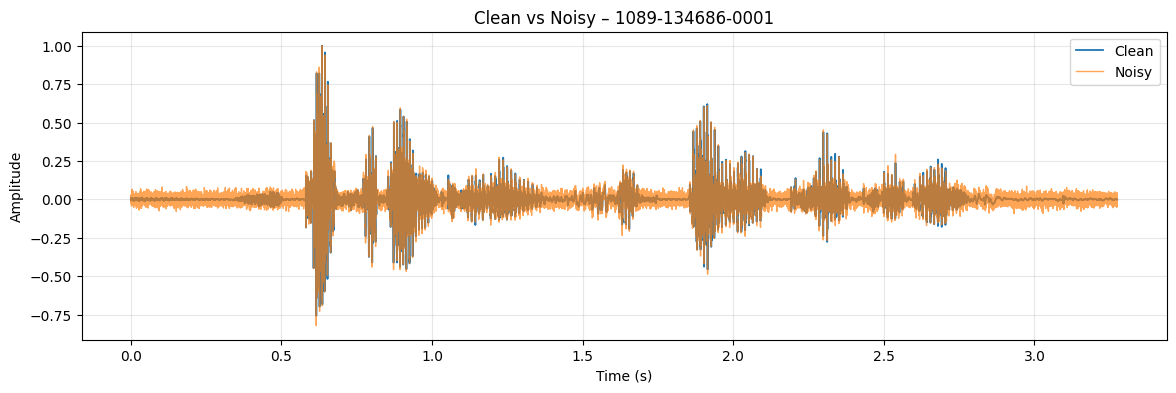

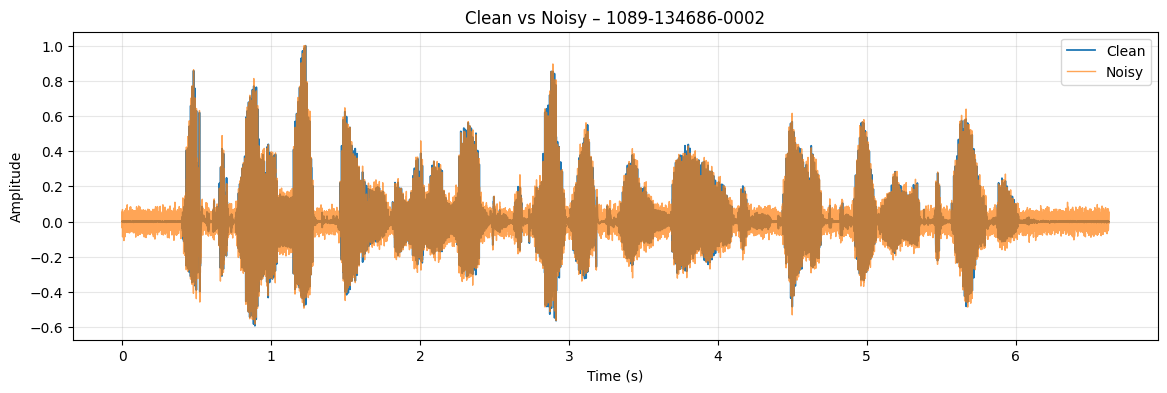

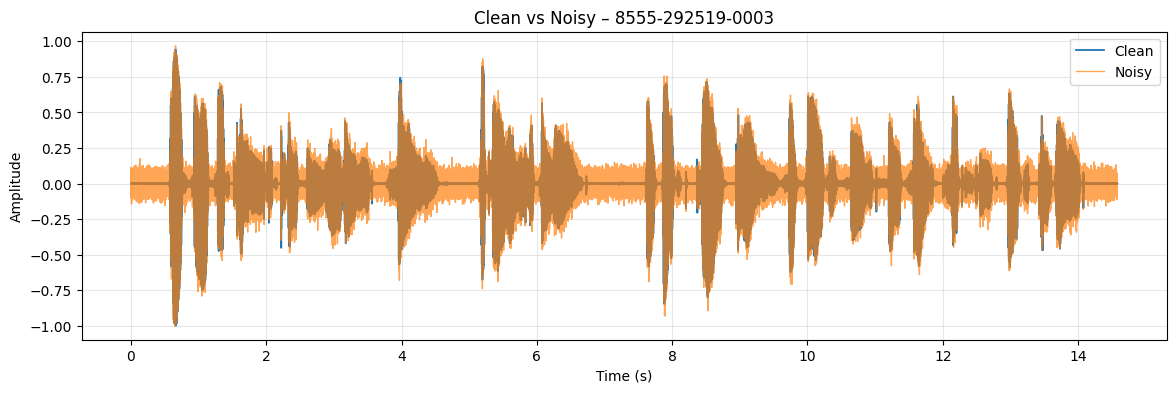

In [ ]:
import os
def visualize_clean_vs_noisy(clean_signal, noisy_signal, sr, title="Clean vs Noisy"):
    import matplotlib.pyplot as plt
    import numpy as np

    t = np.linspace(0, len(clean_signal)/sr, len(clean_signal))

    plt.figure(figsize=(14, 4))
    plt.plot(t, clean_signal, label="Clean", linewidth=1.3)
    plt.plot(t, noisy_signal, label="Noisy", linewidth=1.0, alpha=0.7)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

for file_name in audio_files:
    if "rekaman.wav" in file_name:
        continue

    clean = all_signals[file_name]
    base_name = os.path.basename(file_name)
    name_without_ext = os.path.splitext(base_name)[0]
    noisy_path = f"noisy_10dB_{name_without_ext}.wav"
    try:
        noisy, _ = librosa.load(noisy_path, sr=TARGET_SR)

        visualize_clean_vs_noisy(
            clean, noisy, TARGET_SR,
            title=f"Clean vs Noisy – {name_without_ext}"
        )
    except FileNotFoundError:
        print(f"Peringatan: File {noisy_path} tidak ditemukan di direktori lokal.")

Fungsi ini digunakan untuk memvisualisasikan perbandingan antara sinyal audio bersih (clean) dan sinyal audio yang telah ditambahkan noise (noisy) dalam domain waktu. Visualisasi ini bertujuan untuk menunjukkan pengaruh penambahan noise terhadap bentuk gelombang sinyal audio secara langsung. Selanjutnya, fungsi tersebut dipanggil untuk setiap file audio dataset (kecuali file rekaman asli), dengan memuat kembali file audio noisy yang telah disimpan sebelumnya.

In [ ]:
import matplotlib.pyplot as plt

def visualize_framing(signal, sr, frame_len, hop_len, title):
    duration = 0.1
    sig = signal[:int(duration * sr)]

    plt.figure(figsize=(14,4))
    plt.plot(sig, label="Speech Signal")

    for i in range(0, len(sig) - frame_len, hop_len):
        plt.axvspan(i, i + frame_len, color='orange', alpha=0.25, label='Frame Biasa' if i == 0 else "")

    overlap_len = frame_len - hop_len
    for i in range(0, len(sig) - frame_len, hop_len):
        if i + frame_len + hop_len <= len(sig):
            overlap_start = i + frame_len - overlap_len
            overlap_end = i + frame_len
            plt.axvspan(overlap_start, overlap_end, color='red', alpha=0.6, label='Area Overlap' if i == 0 else "")

    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()

Fungsi ini digunakan untuk memvisualisasikan proses framing sinyal audio dalam domain waktu, termasuk area overlap antar frame. Setiap frame ditandai dengan area berwarna oranye, sedangkan area overlap antar frame ditampilkan dengan warna merah. Visualisasi ini bertujuan untuk memberikan pemahaman mengenai mekanisme pembagian sinyal menjadi frame berdurasi pendek dengan overlap tertentu, yang merupakan tahapan penting dalam pengolahan sinyal suara berbasis frame.

Visualisasi framing: 1089-134686-0001.wav


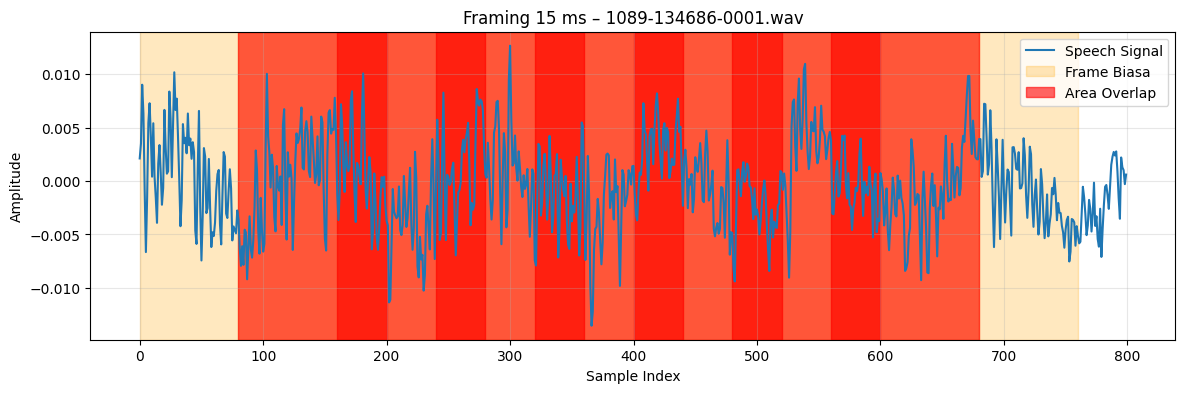

Visualisasi framing: 1089-134686-0002.wav


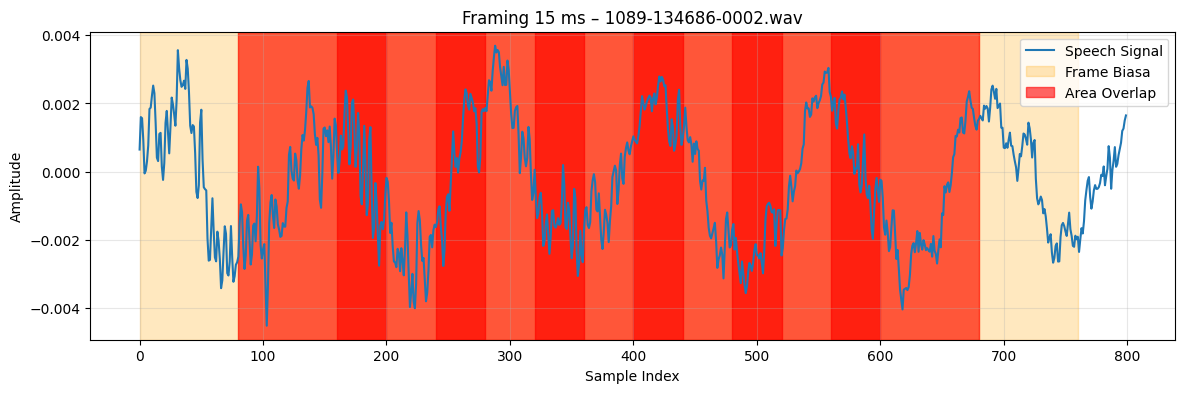

Visualisasi framing: 8555-292519-0003.wav


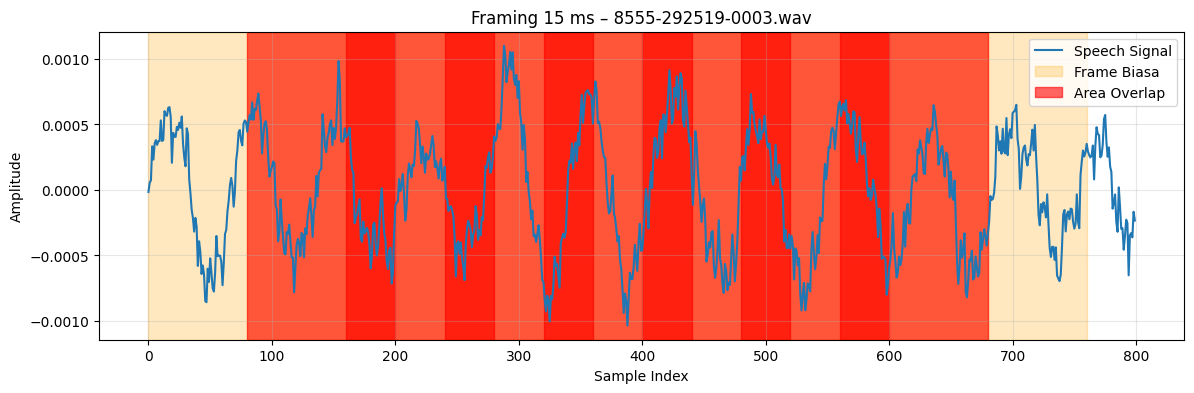

Visualisasi framing: rekaman.wav


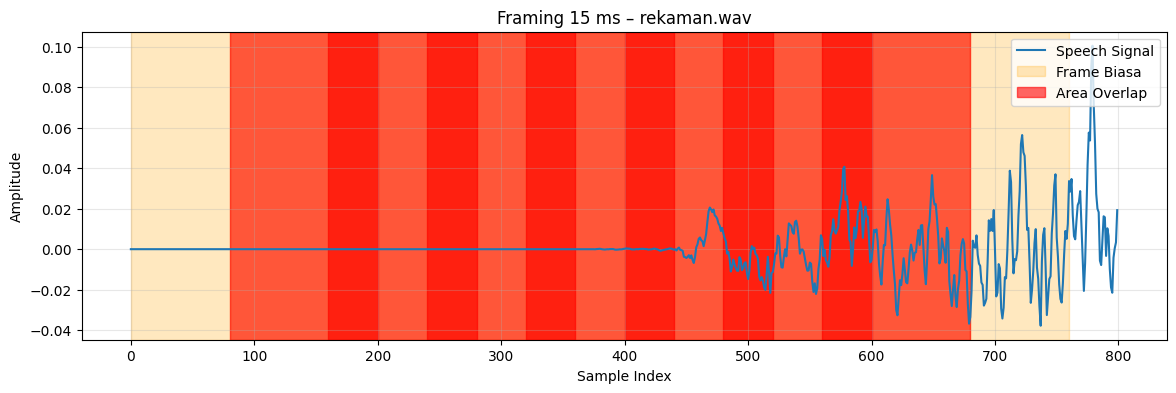

In [ ]:
for file_name in audio_files:
    print(f"Visualisasi framing: {os.path.basename(file_name)}")

    frames, frame_len, hop_len = frame_signal(
        all_signals[file_name],
        TARGET_SR,
        frame_duration_ms=25,
        overlap_percent=0.6
    )

    visualize_framing(
        all_signals[file_name],
        TARGET_SR,
        frame_len,
        hop_len,
        title=f"Framing 15 ms – {os.path.basename(file_name)}"
    )

# Menghitung fitur VAD

## **1. Menghitung STFT Tiap Frame**

In [ ]:
# Feature extraction STFT
def compute_stft_magnitude(frames, n_fft=256):
    stft_mag = []
    for frame in frames:
        spectrum = np.fft.rfft(frame, n=n_fft)
        stft_mag.append(np.abs(spectrum))
    return np.array(stft_mag)

# Dictionary all_frames_hamming kini sudah terisi dari sel sebelumnya (PshMkLN7bVfj)
# Inisialisasi dictionary untuk menyimpan STFT magnitudes untuk semua file
all_stft_magnitudes = {}

for file_name, frames_hamming_for_file in all_frames_hamming.items():
    print(f">>> Menghitung STFT untuk file: {file_name}")

    print("Menghitung STFT setiap frame")
    stft_mag = compute_stft_magnitude(frames_hamming_for_file, n_fft=256)
    all_stft_magnitudes[file_name] = stft_mag # Simpan hasilnya

    print("    -> STFT selesai!")
    print(f"    Jumlah frame        : {stft_mag.shape[0]}")
    print(f"    Panjang FFT (bins)  : {stft_mag.shape[1]}")
    print(f"    Bentuk STFT         : {stft_mag.shape}")

    # Print 5 frame pertama (hanya 10 frekuensi pertama agar tidak panjang)
    print("\n    Contoh nilai STFT frame pertama (10 bin frekuensi awal):")
    if stft_mag.shape[0] > 0: # Pastikan ada frame untuk ditampilkan
        print(stft_mag[0][:10])
    else:
        print("    Tidak ada frame untuk ditampilkan.")

    print("\n    Contoh 3 frame pertama (dipotong 10 bin):")
    for i in range(min(3, stft_mag.shape[0])): # Iterasi hingga 3 frame atau kurang jika tidak cukup
        print(f"    Frame {i}: {stft_mag[i][:10]}")
    print("----------------------------------------------------\n")

>>> Menghitung STFT untuk file: /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav
Menghitung STFT setiap frame
    -> STFT selesai!
    Jumlah frame        : 435
    Panjang FFT (bins)  : 129
    Bentuk STFT         : (435, 129)

    Contoh nilai STFT frame pertama (10 bin frekuensi awal):
[0.0265854  0.12629298 0.2060272  0.23474227 0.22619831 0.17927245
 0.09276213 0.0509874  0.0976588  0.11255072]

    Contoh 3 frame pertama (dipotong 10 bin):
    Frame 0: [0.0265854  0.12629298 0.2060272  0.23474227 0.22619831 0.17927245
 0.09276213 0.0509874  0.0976588  0.11255072]
    Frame 1: [0.11156483 0.14077557 0.18322311 0.20439105 0.22132058 0.25236012
 0.27638049 0.26330692 0.21246269 0.15710588]
    Frame 2: [0.16703602 0.19381007 0.18082453 0.09679119 0.05725107 0.04813902
 0.05226439 0.10819184 0.10439426 0.04778763]
----------------------------------------------------

>>> Menghitung STFT untuk file: /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav

Fungsi ini digunakan untuk menghitung magnitudo Short-Time Fourier Transform (STFT) pada setiap frame sinyal audio yang telah diberi Hamming Window. Proses dilakukan dengan menerapkan Fast Fourier Transform (FFT) berdimensi 256 pada masing-masing frame, kemudian mengambil nilai magnitudo spektrum frekuensi sebagai representasi energi sinyal pada domain frekuensi. Selanjutnya, perhitungan STFT dilakukan untuk seluruh file audio yang telah melalui tahap framing dan windowing.

In [ ]:
def get_energy_pattern(EL, EM, EH):
    # Pattern Voiced
    if EH < EM < EL:
        return 1

    # Pattern Unvoiced – 3 pola
    if EH > EM > EL:
        return 2
    if EH > EL > EM:
        return 3
    if EM > EH > EL:
        return 4

    # Pattern tidak cocok → ambiguous → gunakan ZCR
    return 0

Fungsi ini digunakan untuk mengklasifikasikan pola distribusi energi spektral pada tiga sub-band frekuensi, yaitu low (EL), mid (EM), dan high (EH). Jika energi terbesar berada pada frekuensi rendah dan menurun ke frekuensi tinggi (EL > EM > EH), maka sinyal diklasifikasikan sebagai voiced speech. Sebaliknya, beberapa kombinasi pola energi dengan dominasi frekuensi tinggi diklasifikasikan sebagai unvoiced speech.

### **ekstraksi fitur STFT**

In [ ]:
import numpy as np

In [ ]:
def calculate_subband_energies(stft_magnitudes, sample_rate=8000, n_fft=256):

    # 1. Tentukan frekuensi untuk setiap bin dalam FFT
    # rfftfreq menghasilkan array frekuensi pusat untuk setiap bin
    freqs = np.fft.rfftfreq(n_fft, d=1/sample_rate)

    # 2. Cari indeks array yang mendekati batas frekuensi (1200 Hz dan 3000 Hz)
    # Mencari indeks di mana frekuensi >= threshold
    idx_1200 = np.searchsorted(freqs, 1200)
    idx_3000 = np.searchsorted(freqs, 3000)

    subband_energies = []

    # Proses setiap frame
    for frame_mag in stft_magnitudes:
        # Kuadratkan magnitude untuk mendapatkan Power/Energy (sesuai persamaan 2-4)
        frame_power = frame_mag ** 2

        # Hitung EL (Low Band Energy): 0 - 1200 Hz
        # Jurnal Persamaan (2): Sum dari bin 1 sampai TH1
        EL = np.sum(frame_power[:idx_1200])

        # Hitung EM (Mid Band Energy): 1200 - 3000 Hz
        # Jurnal Persamaan (3): Sum dari bin TH1+1 sampai TH2
        EM = np.sum(frame_power[idx_1200:idx_3000])

        # Hitung EH (High Band Energy): 3000 Hz - Selesai (4000 Hz)
        # Jurnal Persamaan (4): Sum dari bin TH2+1 sampai N
        EH = np.sum(frame_power[idx_3000:])

        subband_energies.append({
            'EL': EL,
            'EM': EM,
            'EH': EH
        })

    return subband_energies

# --- EKSEKUSI ---
all_energies = {}

# Asumsi sample rate 8000 Hz seperti di jurnal (Page 5, Section 4 Experiment Details) [cite: 591]
SAMPLE_RATE = 8000

for file_name, stft_mag in all_stft_magnitudes.items():
    print(f">>> Menghitung Energi Sub-band untuk file: {file_name}")

    energies = calculate_subband_energies(stft_mag, sample_rate=SAMPLE_RATE, n_fft=256)
    all_energies[file_name] = energies

    print("    -> Perhitungan energi selesai!")

    # Tampilkan contoh 3 frame pertama
    print("\n    Contoh Energi 3 frame pertama:")
    for i in range(min(3, len(energies))):
        e = energies[i]
        print(f"    Frame {i}: EL={e['EL']:.4f}, EM={e['EM']:.4f}, EH={e['EH']:.4f}")
    print("----------------------------------------------------\n")

>>> Menghitung Energi Sub-band untuk file: /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav
    -> Perhitungan energi selesai!

    Contoh Energi 3 frame pertama:
    Frame 0: EL=1.2389, EM=2.3723, EH=0.7617
    Frame 1: EL=1.1223, EM=1.5887, EH=0.9424
    Frame 2: EL=0.9246, EM=1.3873, EH=0.6128
----------------------------------------------------

>>> Menghitung Energi Sub-band untuk file: /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav
    -> Perhitungan energi selesai!

    Contoh Energi 3 frame pertama:
    Frame 0: EL=2.2241, EM=2.4959, EH=1.0261
    Frame 1: EL=1.3284, EM=2.2006, EH=1.4681
    Frame 2: EL=1.6540, EM=2.3443, EH=0.6296
----------------------------------------------------

>>> Menghitung Energi Sub-band untuk file: /content/drive/MyDrive/Project PSD  Kelompok 7/8555-292519-0003.wav
    -> Perhitungan energi selesai!

    Contoh Energi 3 frame pertama:
    Frame 0: EL=5.8299, EM=8.1796, EH=3.8135
    Frame 1: EL=4.2418, EM=5.14

Fungsi ini digunakan untuk menghitung energi spektral pada tiga sub-band frekuensi, yaitu low band (EL), mid band (EM), dan high band (EH), berdasarkan magnitudo STFT setiap frame. Frekuensi pusat setiap bin FFT ditentukan terlebih dahulu, kemudian indeks bin yang mendekati batas frekuensi 1200 Hz dan 3000 Hz digunakan sebagai pemisah antar sub-band.

In [ ]:
#gausah masuk laporan, cuma buat ngecek ada energi atau tidak pada rekaman suara kita..
energies = all_energies["/content/drive/MyDrive/Project PSD  Kelompok 7/rekaman.wav"]

print("Min & Max Energi:")
print(
    min(e['EL'] + e['EM'] + e['EH'] for e in energies),
    max(e['EL'] + e['EM'] + e['EH'] for e in energies)
)

print("Cek apakah semuanya ZERO?")
print(all((e['EL'] + e['EM'] + e['EH']) == 0 for e in energies))


Min & Max Energi:
13.738373787318155 957.4896788272725
Cek apakah semuanya ZERO?
False


## **2. Menghitung ZCR Tiap Frame**

In [ ]:
def compute_zcr(frames):
    zcr_values = []
    for frame in frames:
        # sign(x) menghasilkan +1, 0, atau -1
        signs = np.sign(frame)
        # Hitung jumlah zero crossing (perubahan tanda)
        zero_crossings = np.sum(np.abs(np.diff(signs))) / 2
        # Normalisasi dengan panjang frame
        zcr = zero_crossings / len(frame)
        zcr_values.append(zcr)
    return zcr_values

# Hitung ZCR
all_zcr = {}

for file_name in audio_files:
    frames, _, _ = frame_signal(
        all_signals[file_name],
        TARGET_SR,
        frame_duration_ms=15,
        overlap_percent=0.5
    )
    zcr_values = compute_zcr(frames)
    all_zcr[file_name] = zcr_values

Fungsi ini digunakan untuk menghitung Zero Crossing Rate (ZCR) pada setiap frame sinyal audio. ZCR dihitung berdasarkan jumlah perubahan tanda sinyal dari positif ke negatif atau sebaliknya dalam satu frame, kemudian dinormalisasi terhadap panjang frame. Nilai ZCR mencerminkan karakteristik frekuensi sinyal, di mana nilai yang tinggi menunjukkan dominasi frekuensi tinggi atau unvoiced speech, sedangkan nilai yang rendah menunjukkan voiced speech.

Selanjutnya, perhitungan ZCR dilakukan untuk setiap file audio dengan menggunakan frame berdurasi 15 ms dan overlap 50%.

## **3. Decision Logic/ Klasifikasi Frame**

In [ ]:
def vad_classify_journal(energies, zcr_values, zcr_fixed=0.038):
    """
    Implementasi asli jurnal:
    1) Energy-ratio pattern (EL, EM, EH)
    2) Jika tidak cocok → fallback ke ZCR < 3.8 per ms
    """

    labels = []
    for i, e in enumerate(energies):
        EL, EM, EH = e["EL"], e["EM"], e["EH"]

        pattern = get_energy_pattern(EL, EM, EH)

        if pattern == 1:
            labels.append("Voiced")
        elif pattern in [2, 3, 4]:
            labels.append("Unvoiced")
        else:
            # fallback ZCR
            if zcr_values[i] < zcr_fixed:
                labels.append("Voiced")
            else:
                labels.append("Unvoiced")

    return labels

Fungsi ini mengimplementasikan algoritma Voice Activity Detection (VAD) berdasarkan pendekatan yang diadaptasi dari jurnal acuan. Proses klasifikasi dilakukan dengan memanfaatkan pola rasio energi sub-band (EL, EM, dan EH) sebagai kriteria utama untuk membedakan antara voiced dan unvoiced speech. Jika pola energi tidak memenuhi kriteria tertentu (ambiguous), maka keputusan klasifikasi dilakukan menggunakan Zero Crossing Rate (ZCR) sebagai fitur cadangan.

In [ ]:
vad_labels = {}  # <= ini membuat dictionary kosong

for file_name in audio_files:
    energies = all_energies[file_name]
    zcr_values = all_zcr[file_name]

    vad_labels[file_name] = vad_classify_journal(
        energies,
        zcr_values,
        zcr_fixed=0.038   # threshold tetap sesuai jurnal
    )

# tampilkan hasil klasifikasi
for f in audio_files:
    print(f"\n--- {f} ---")
    # The line below was causing the NameError and was redundant for classification
    # vad_labels[f] = vad_classify(all_energies[f], all_zcr[f], energy_thresholds[f], zcr_thresholds[f])
    print(f"Labels 10 frame pertama: {vad_labels[f][:10]}")


--- /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav ---
Labels 10 frame pertama: ['Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Voiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced']

--- /content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav ---
Labels 10 frame pertama: ['Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced']

--- /content/drive/MyDrive/Project PSD  Kelompok 7/8555-292519-0003.wav ---
Labels 10 frame pertama: ['Unvoiced', 'Unvoiced', 'Voiced', 'Unvoiced', 'Voiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced']

--- /content/drive/MyDrive/Project PSD  Kelompok 7/rekaman.wav ---
Labels 10 frame pertama: ['Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Unvoiced', 'Voiced', 'Unvoiced', 'Unvoiced']


## **4 Smoothing/Post-processing**

In [ ]:
def smooth_labels(labels, frame_duration_ms=15.0, min_voiced_ms=50, min_silence_ms=50):
    """
    Simple smoothing:
     - remove voiced segments shorter than min_voiced_ms (convert to silence)
     - remove silence segments shorter than min_silence_ms (convert to previous label)
    labels: list of strings
    returns: smoothed labels
    """
    labels = list(labels)
    n = len(labels)
    if n == 0:
        return labels

    frames_per_voiced = max(1, int(np.round(min_voiced_ms / frame_duration_ms)))
    frames_per_silence = max(1, int(np.round(min_silence_ms / frame_duration_ms)))

    # function to find segments (start,end,label)
    segs = []
    start = 0
    cur = labels[0]
    for i in range(1, n):
        if labels[i] != cur:
            segs.append((start, i-1, cur))
            start = i
            cur = labels[i]
    segs.append((start, n-1, cur))

    # apply voiced removal - PERBAIKI INDENTASI INI
    new_labels = labels.copy()
    for (s,e,lbl) in segs:
        length = e - s + 1
        if lbl == "Voiced" and length < frames_per_voiced:
            for i in range(s, e+1):
                new_labels[i] = "Unvoiced"

    labels2 = new_labels
    segs2 = []
    start = 0
    cur = labels2[0]
    for i in range(1, n):
        if labels2[i] != cur:
            segs2.append((start, i-1, cur))
            start = i
            cur = labels2[i]
    segs2.append((start, n-1, cur))

    for (s,e,lbl) in segs2:
        length = e - s + 1
        if lbl == "Unvoiced" and length < frames_per_silence:
            left_lbl = labels2[s-1] if s-1 >= 0 else None
            right_lbl = labels2[e+1] if e+1 < n else None
            prefer = left_lbl if left_lbl is not None else right_lbl
            if prefer is None:
                prefer = "Unvoiced"  # fallback
            for i in range(s, e+1):
                labels2[i] = prefer

    return labels2

Kode ini dipakai untuk merapikan hasil VAD supaya tidak terlalu patah-patah. Kalau ada suara yang muncul sangat singkat, misalnya cuma satu atau dua frame, maka dianggap noise dan diubah jadi unvoiced.
Sebaliknya, kalau ada jeda hening yang terlalu pendek di tengah suara, maka digabung kembali ke suara di sekitarnya.

Dengan smoothing ini, hasil deteksi suara jadi lebih stabil dan lebih mirip dengan pola bicara manusia.

#Visualisasi

## Visualisasi 1: Spectogram


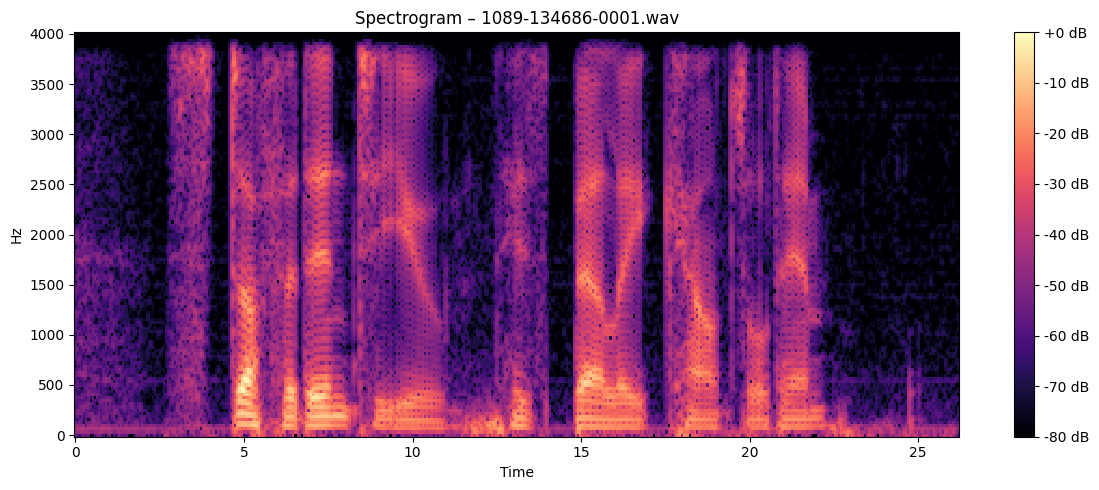

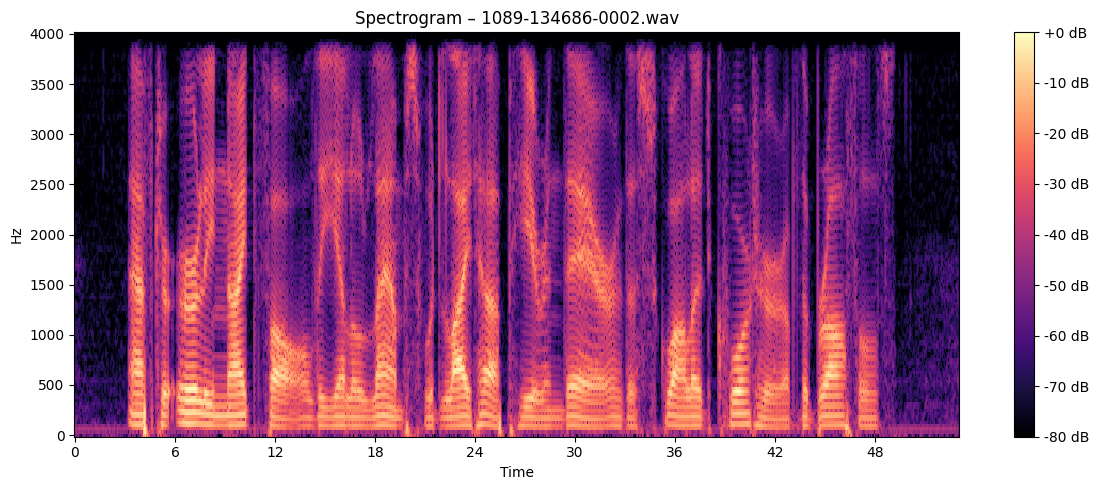

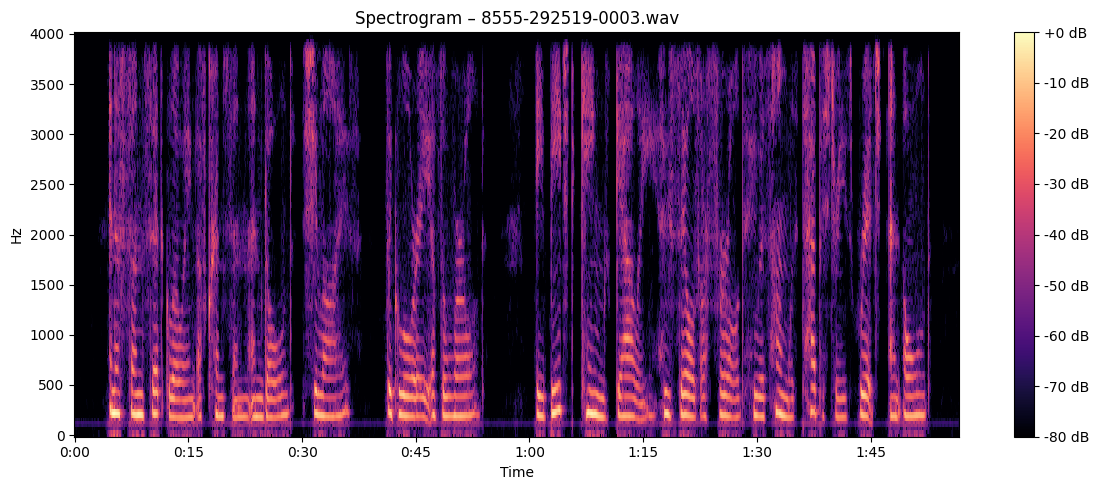

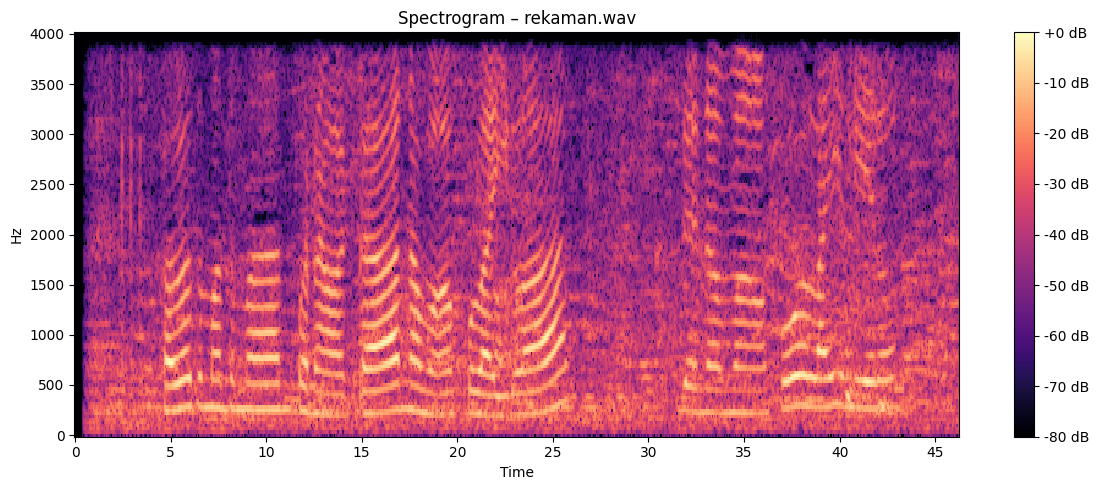

In [ ]:
def plot_spectrogram(signal, sr, title="Spectrogram"):
    import matplotlib.pyplot as plt
    import librosa.display
    import numpy as np

    S = np.abs(librosa.stft(signal, n_fft=256))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 5))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for file_name in audio_files:
    signal = all_signals[file_name]
    sr = all_sample_rates[file_name]

    base_name = os.path.basename(file_name)   # ← buat variabel dulu

    plot_spectrogram(
        signal, sr,
        title=f"Spectrogram – {base_name}"
    )

Fungsi ini digunakan untuk menampilkan spektrogram sinyal audio berdasarkan hasil Short-Time Fourier Transform (STFT). Magnitudo STFT dihitung dengan panjang FFT sebesar 256, kemudian dikonversi ke skala desibel (dB) untuk mempermudah pengamatan distribusi energi sinyal pada berbagai frekuensi terhadap waktu.

## Visualisasi 2: Waferom + Label

###Raw VAD

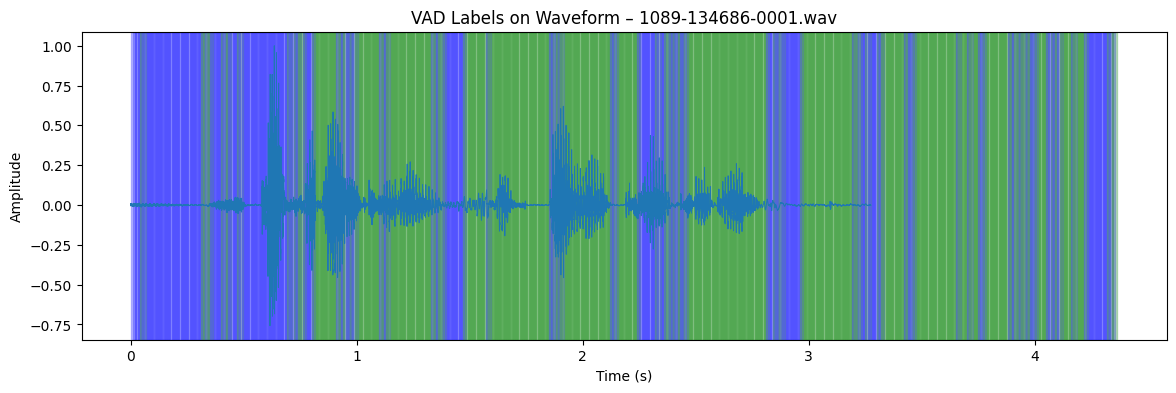

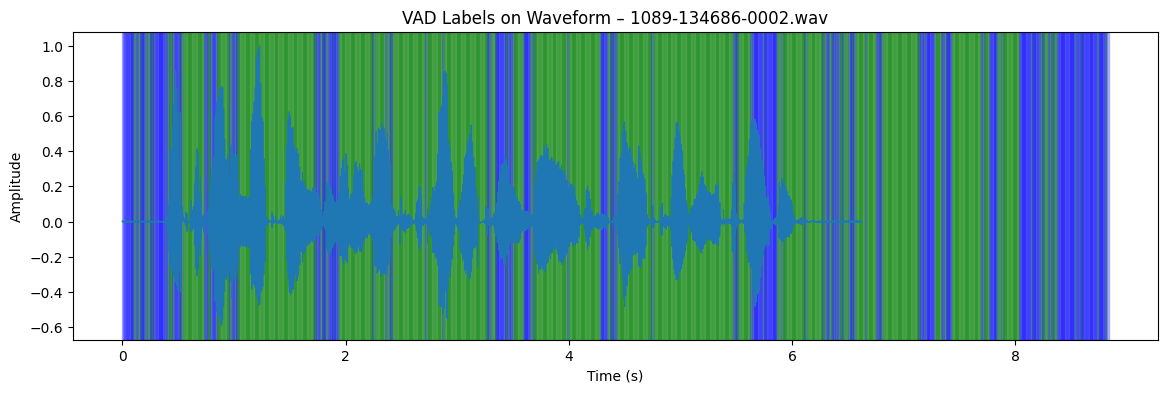

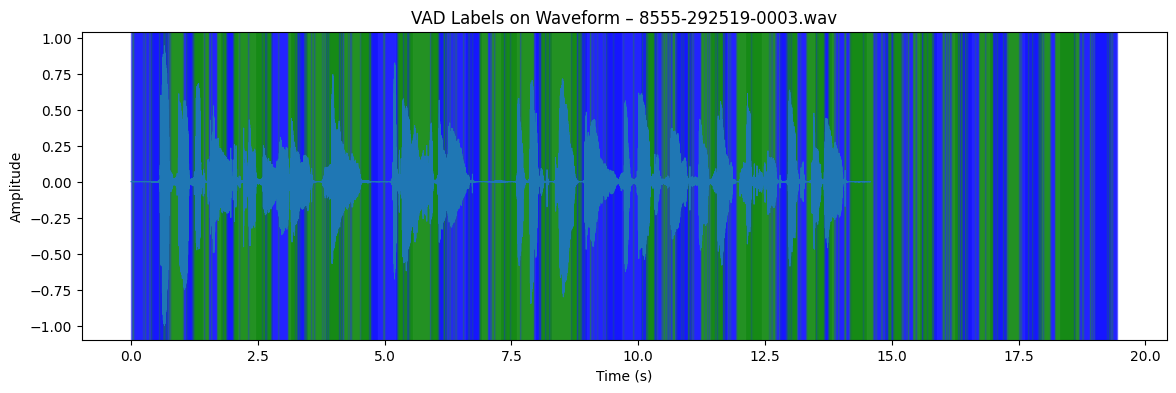

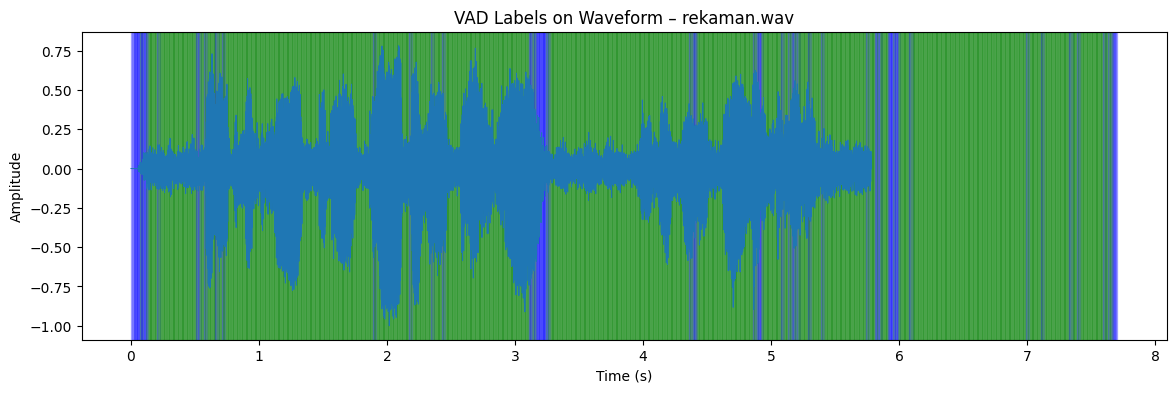

In [ ]:
def plot_labels_on_waveform(signal, sr, labels, frame_len, hop_len, title="VAD Labels on Waveform"):
    import matplotlib.pyplot as plt
    import numpy as np

    times = np.arange(len(signal)) / sr
    plt.figure(figsize=(14, 4))
    plt.plot(times, signal, linewidth=0.7)

    # Hanya dua label sesuai metode jurnal
    color_map = {
        "Voiced": "green",
        "Unvoiced": "blue"
    }

    for i, lbl in enumerate(labels):
        if lbl not in color_map:
            continue  # Safety: skip label tidak dikenal

        start = (i * hop_len) / sr
        end = (i * hop_len + frame_len) / sr
        plt.axvspan(start, end, color=color_map[lbl], alpha=0.25)

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


# PEMANGGILAN YANG BENAR:
for file_name in audio_files:
    signal = all_signals[file_name]
    sr = all_sample_rates[file_name]
    labels = vad_labels[file_name]

    base_name = os.path.basename(file_name)

    plot_labels_on_waveform(
        signal, sr, labels, frame_len, hop_len,
        title=f"VAD Labels on Waveform – {base_name}"
    )


Fungsi ini digunakan untuk memvisualisasikan hasil klasifikasi Voice Activity Detection (VAD) langsung pada gelombang sinyal audio. Setiap frame diberi penanda warna sesuai dengan label hasil klasifikasi, di mana warna hijau menunjukkan segmen voiced dan warna biru menunjukkan segmen unvoiced.

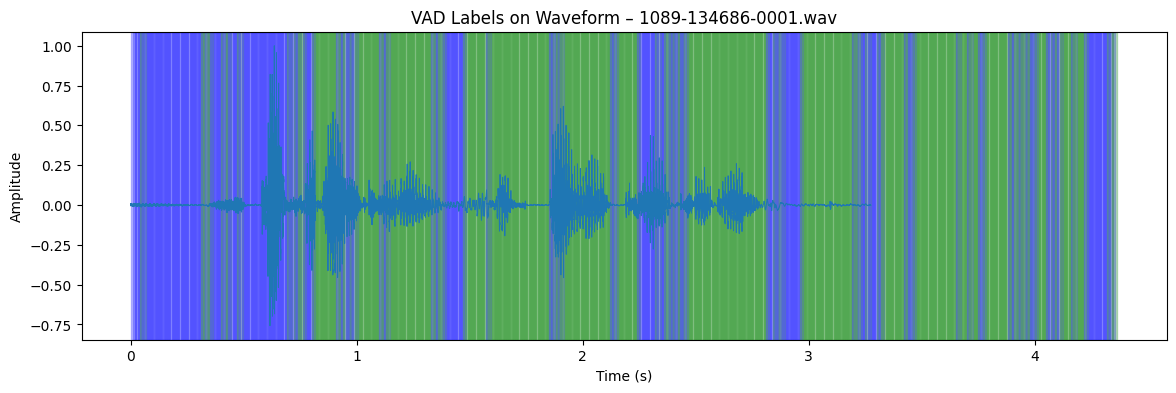

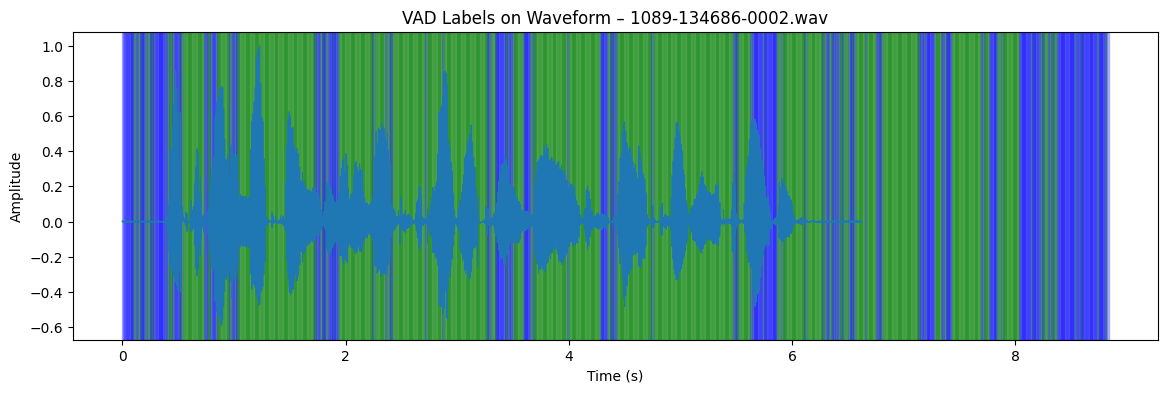

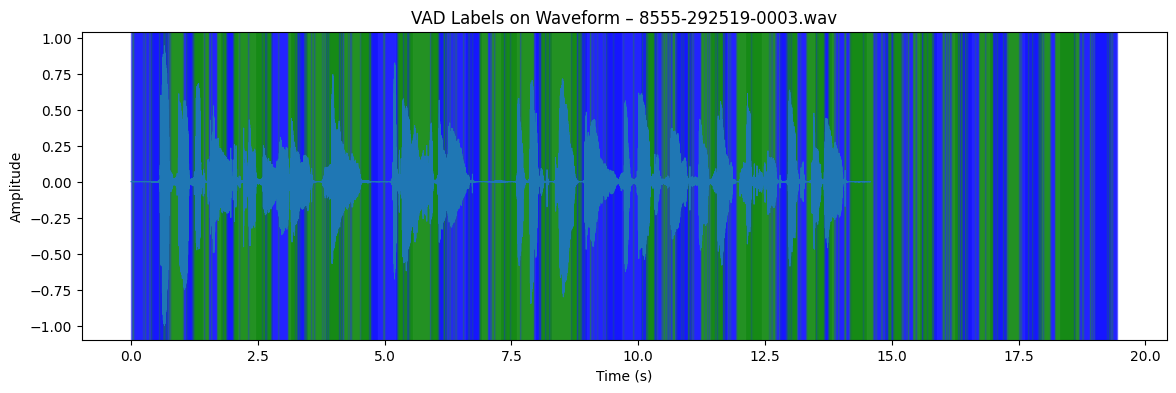

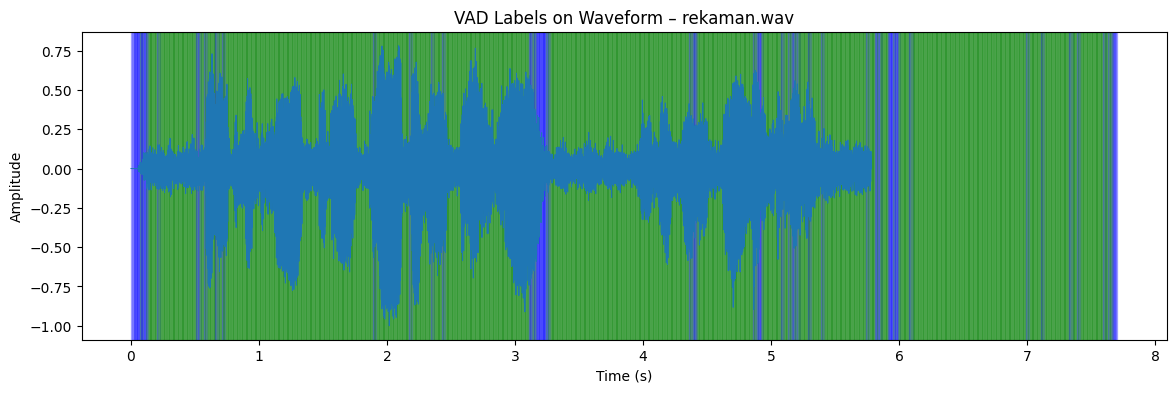

In [ ]:
for file_name in audio_files:
    signal = all_signals[file_name]
    sr = all_sample_rates[file_name]
    labels = vad_labels[file_name]

    base_name = os.path.basename(file_name)  # <-- ini yang benar

    plot_labels_on_waveform(
        signal, sr, labels, frame_len, hop_len,
        title=f"VAD Labels on Waveform – {base_name}"
    )

###Raw vs Smoothed Comparison

In [ ]:
def run_vad_for_file(file_name, frame_len_samples, hop_len_samples,
                     all_energies, all_zcr, all_signals, all_sample_rates,
                     zcr_threshold,  # TAMBAH PARAMETER INI
                     all_stft_magnitudes=None, smoothing=True):

    energies = all_energies[file_name]
    zcr_vals = all_zcr[file_name]

    # RAW LABELS (pakai threshold yang diberikan)
    raw_labels = vad_classify_journal(energies, zcr_vals, zcr_threshold)

    # APPLY SMOOTHING
    if smoothing:
        labels = smooth_labels(raw_labels,
                               frame_duration_ms=(frame_len_samples / all_sample_rates[file_name]) * 1000.0)
    else:
        labels = raw_labels

    # get signal and sr
    signal = all_signals[file_name]
    sr = all_sample_rates[file_name]

    # plotting STFT
    stft_mag = all_stft_magnitudes.get(file_name) if all_stft_magnitudes else None

    return raw_labels, labels

Fungsi ini digunakan untuk menjalankan proses Voice Activity Detection (VAD) pada satu file audio secara lengkap. Proses dimulai dengan mengambil fitur energi sub-band dan nilai Zero Crossing Rate (ZCR), kemudian dilakukan klasifikasi voiced dan unvoiced menggunakan metode berbasis jurnal dengan nilai threshold ZCR yang diberikan sebagai parameter.

In [ ]:
def plot_raw_vs_smooth(signal, sr, raw_labels, smooth_labels,
                       frame_len_samples, hop_len_samples,
                       title="Raw VAD vs Smoothed VAD"):
    import matplotlib.pyplot as plt
    import numpy as np

    times = np.arange(len(signal)) / sr

    # Colors
    color_map = {"Voiced":"green", "Unvoiced":"blue"}  # Hapus Silence

    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # --- 1. Raw VAD ---
    axs[0].plot(times, signal, linewidth=0.7)
    axs[0].set_title(title + " (RAW)")
    for i, lbl in enumerate(raw_labels):
        start = (i * hop_len_samples) / sr
        end   = (i * hop_len_samples + frame_len_samples) / sr
        axs[0].axvspan(start, end, color=color_map[lbl], alpha=0.25)
    axs[0].set_ylabel("Amplitude")

    # --- 2. Smoothed VAD ---
    axs[1].plot(times, signal, linewidth=0.7)
    axs[1].set_title(title + " (SMOOTHED)")
    for i, lbl in enumerate(smooth_labels):
        start = (i * hop_len_samples) / sr
        end   = (i * hop_len_samples + frame_len_samples) / sr
        axs[1].axvspan(start, end, color=color_map[lbl], alpha=0.25)

    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()


Fungsi ini digunakan untuk menampilkan perbandingan hasil Voice Activity Detection (VAD) sebelum dan sesudah proses smoothing pada sinyal audio. Visualisasi dibagi menjadi dua bagian, di mana grafik pertama menunjukkan hasil klasifikasi VAD mentah (raw), dan grafik kedua menunjukkan hasil VAD setelah dilakukan smoothing.

Setiap frame diberi penanda warna untuk menunjukkan segmen voiced dan unvoiced di atas sinyal audio. Perbandingan ini membantu menunjukkan efek smoothing dalam mengurangi segmentasi yang terputus-putus.

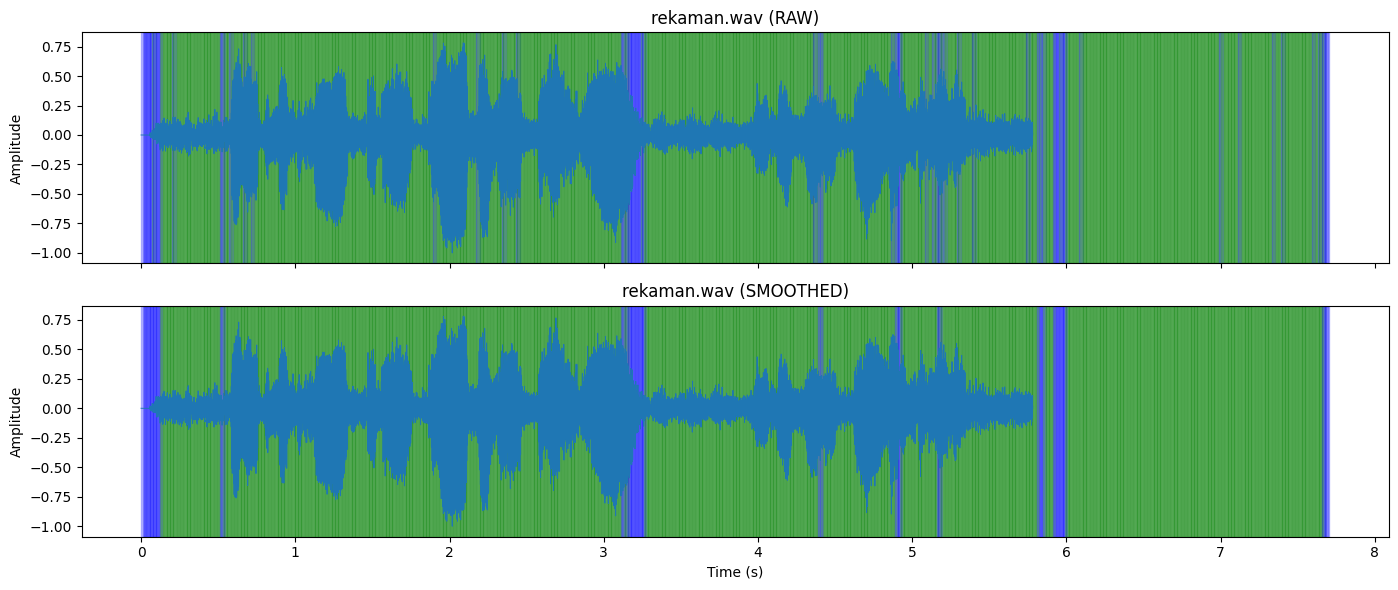

In [ ]:
import os

# NOTE: energy_thresholds is still a dictionary, zcr_thresholds is not used anymore.
# The 'run_vad_for_file' function was modified to access the global 'zcr_threshold_fixed'.

raw_lbls, smoothed_lbls = run_vad_for_file(
    "/content/drive/MyDrive/Project PSD  Kelompok 7/rekaman.wav",
    frame_len,
    hop_len,
    all_energies,
    all_zcr,
    all_signals,
    all_sample_rates,
    0.038,  # ← GANTI INI (threshold ZCR tetap dari jurnal)
    all_stft_magnitudes,
    smoothing=True
)

plot_raw_vs_smooth(
    all_signals["/content/drive/MyDrive/Project PSD  Kelompok 7/rekaman.wav"],
    all_sample_rates["/content/drive/MyDrive/Project PSD  Kelompok 7/rekaman.wav"],
    raw_lbls,
    smoothed_lbls,
    frame_len,
    hop_len,
    title=f"rekaman.wav"
)

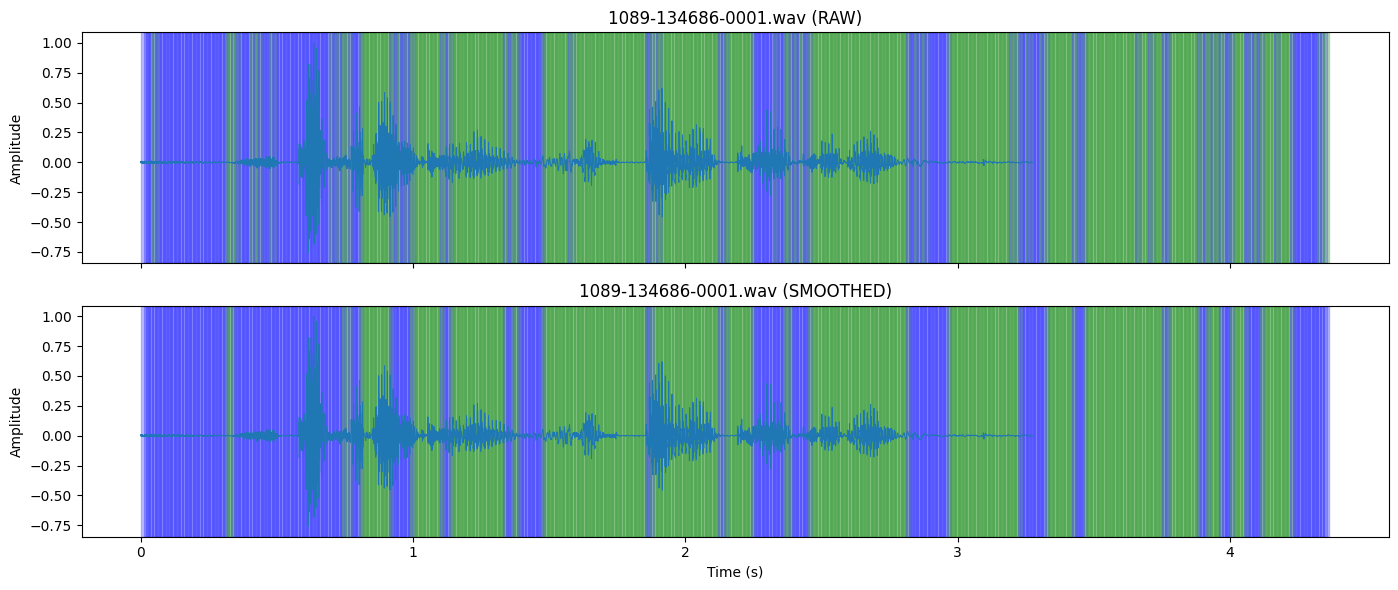

In [ ]:
raw_lbls, smoothed_lbls = run_vad_for_file(
    "/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav",
    frame_len,
    hop_len,
    all_energies,
    all_zcr,
    all_signals,
    all_sample_rates,
    0.038,
    all_stft_magnitudes,
    smoothing=True
)

plot_raw_vs_smooth(
    all_signals["/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav"],
    all_sample_rates["/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0001.wav"],
    raw_lbls,
    smoothed_lbls,
    frame_len,
    hop_len,
    title="1089-134686-0001.wav"
)

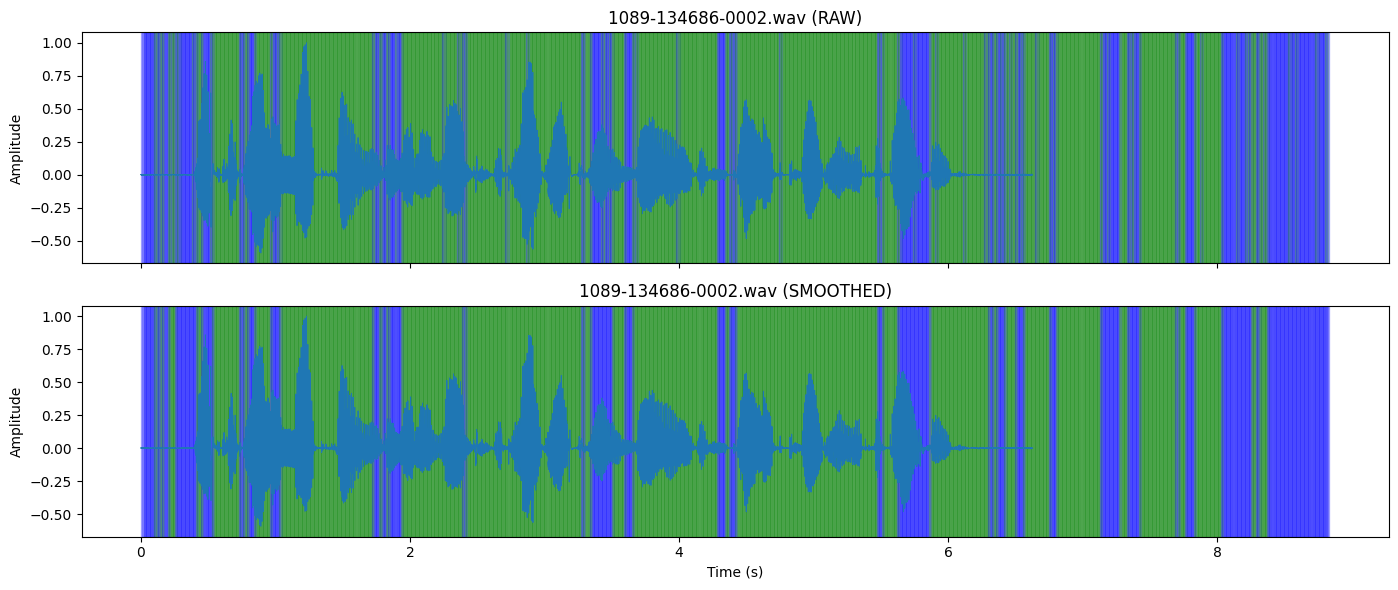

In [ ]:
raw_lbls, smoothed_lbls = run_vad_for_file(
    "/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav",
    frame_len,
    hop_len,
    all_energies,
    all_zcr,
    all_signals,
    all_sample_rates,
    0.038,
    all_stft_magnitudes,
    smoothing=True
)

plot_raw_vs_smooth(
    all_signals["/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav"],
    all_sample_rates["/content/drive/MyDrive/Project PSD  Kelompok 7/1089-134686-0002.wav"],
    raw_lbls,
    smoothed_lbls,
    frame_len,
    hop_len,
    title="1089-134686-0002.wav"
)

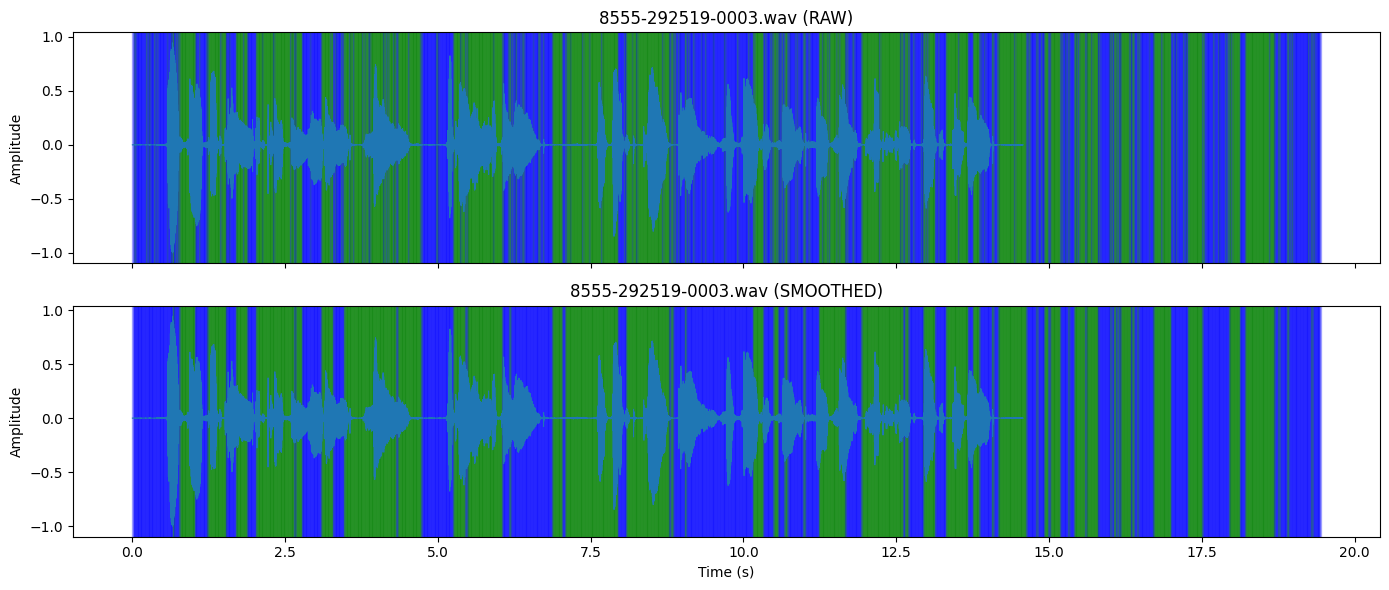

In [ ]:
raw_lbls, smoothed_lbls = run_vad_for_file(
    "/content/drive/MyDrive/Project PSD  Kelompok 7/8555-292519-0003.wav",
    frame_len,
    hop_len,
    all_energies,
    all_zcr,
    all_signals,
    all_sample_rates,
    0.038,
    all_stft_magnitudes,
    smoothing=True
)

plot_raw_vs_smooth(
    all_signals["/content/drive/MyDrive/Project PSD  Kelompok 7/8555-292519-0003.wav"],
    all_sample_rates["/content/drive/MyDrive/Project PSD  Kelompok 7/8555-292519-0003.wav"],
    raw_lbls,
    smoothed_lbls,
    frame_len,
    hop_len,
    title="8555-292519-0003.wav"
)

## visualisasi 3: zcr per frame

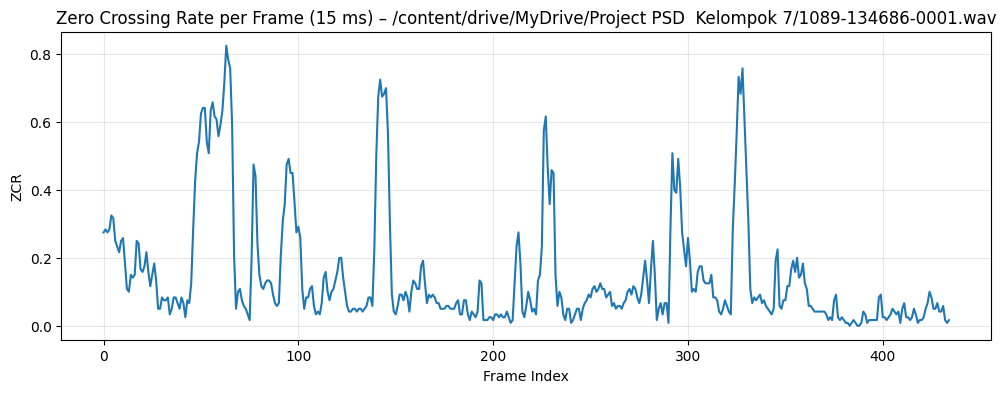

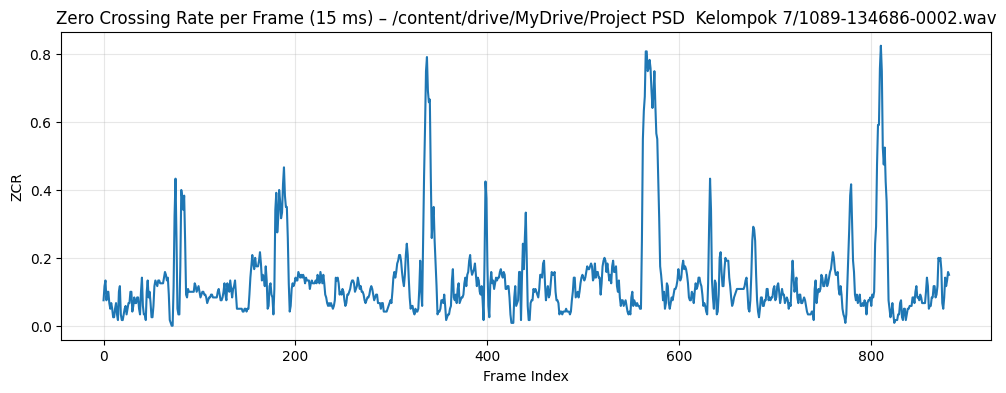

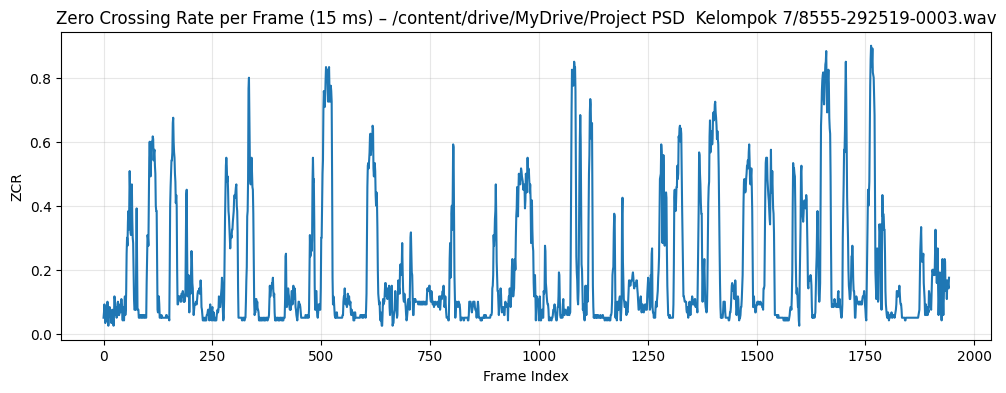

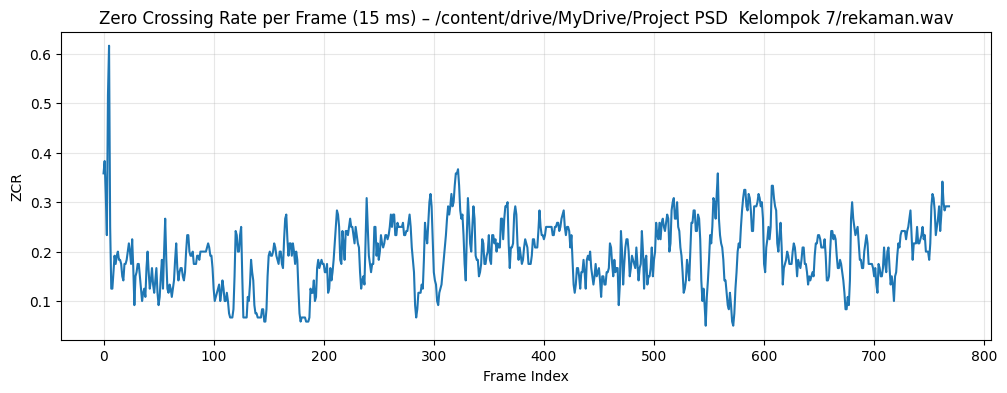

In [ ]:
import matplotlib.pyplot as plt

for file_name, zcr_values in all_zcr.items():
    plt.figure(figsize=(12, 4))
    plt.plot(zcr_values)
    plt.title(f"Zero Crossing Rate per Frame (15 ms) – {file_name}")
    plt.xlabel("Frame Index")
    plt.ylabel("ZCR")
    plt.grid(alpha=0.3)
    plt.show()


Kode ini digunakan untuk menampilkan grafik Zero Crossing Rate (ZCR) per frame untuk setiap file audio. Nilai ZCR diplot terhadap indeks frame dengan durasi frame 15 ms, sehingga menunjukkan perubahan karakteristik frekuensi sinyal suara dari waktu ke waktu.

Visualisasi ini membantu mengidentifikasi perbedaan antara segmen voiced yang umumnya memiliki nilai ZCR rendah dan segmen unvoiced atau noise yang memiliki nilai ZCR lebih tinggi.

## visualisasi 4: energi perframe

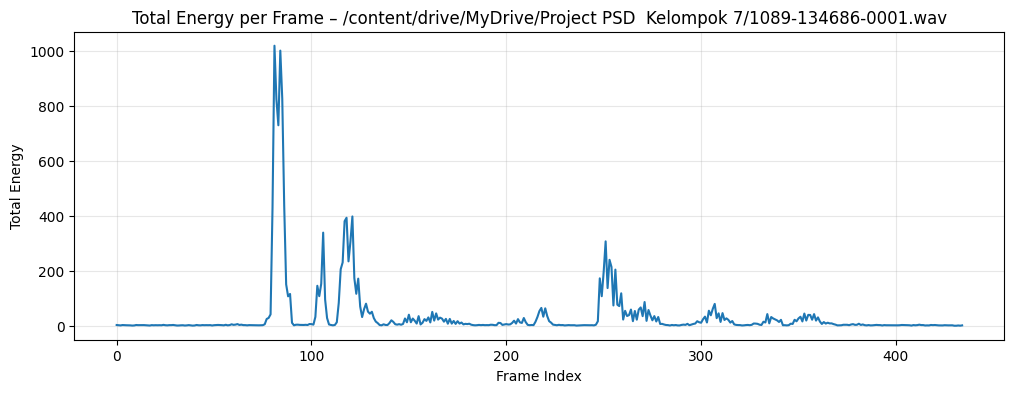

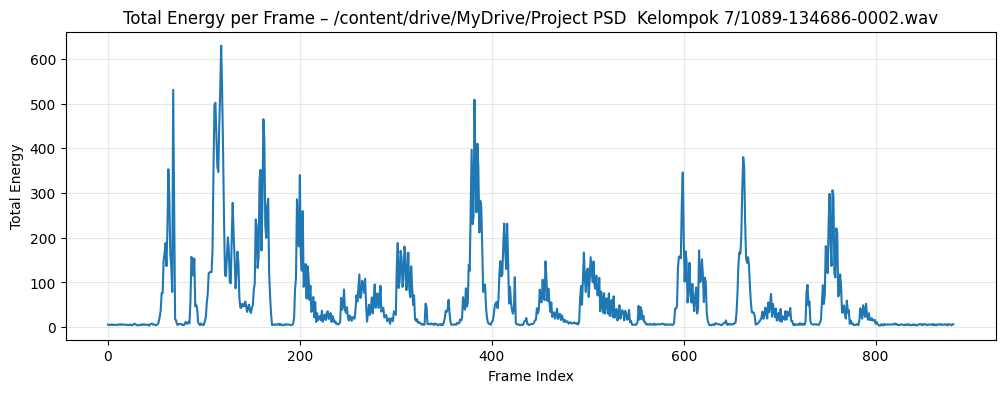

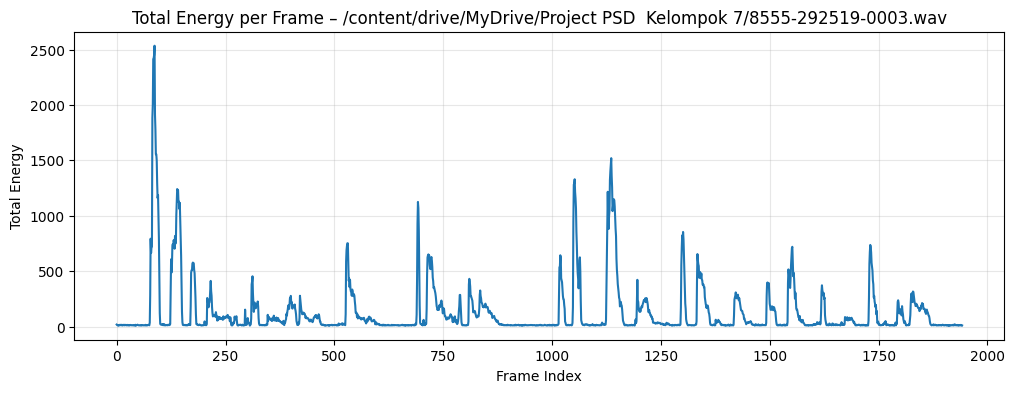

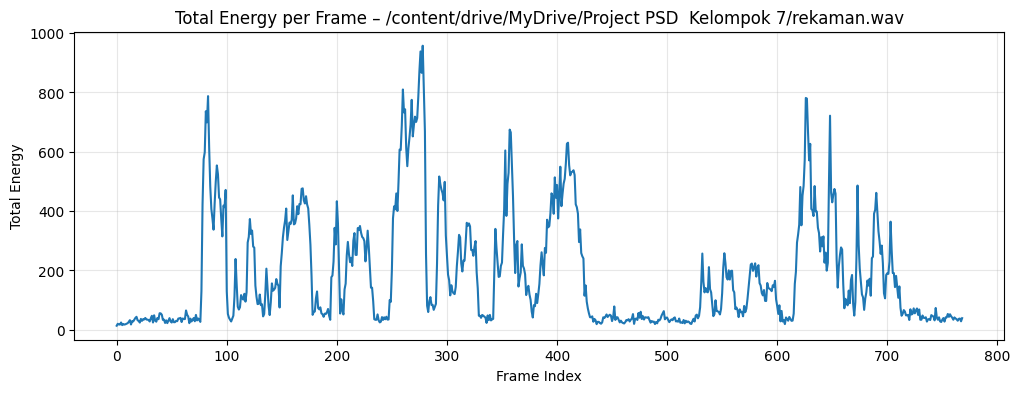

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy for calculations if needed, though simple summing is fine

for file_name, energy_values in all_energies.items():
    plt.figure(figsize=(12, 4))
    # Extract the sum of EL, EM, EH for each frame
    total_energy_per_frame = [e['EL'] + e['EM'] + e['EH'] for e in energy_values]
    plt.plot(total_energy_per_frame)
    plt.title(f"Total Energy per Frame – {file_name}") # Changed title to reflect total energy
    plt.xlabel("Frame Index")
    plt.ylabel("Total Energy") # Changed label to reflect total energy
    plt.grid(alpha=0.3)
    plt.show()

Kode ini digunakan untuk menampilkan grafik total energi sinyal per frame untuk setiap file audio. Total energi dihitung sebagai penjumlahan energi sub-band rendah (EL), menengah (EM), dan tinggi (EH) pada setiap frame. Visualisasi ini menunjukkan perubahan intensitas energi sinyal dari waktu ke waktu dan digunakan untuk mengidentifikasi segmen aktif (ucapan) dan segmen berenergi rendah (keheningan atau noise).